This workbook contains code that reads in the NHLdatasets that were generously provided by Martin Ellis on Kaggle. Here is a direct link to the Kaggle website so that those who have interest can further explore the game data. (https://www.kaggle.com/datasets/martinellis/nhl-game-data/data?select=player_info.csv)

Please note, that the files are both numerous and large. For example, the game_plays.csv file is 765.13MB. This makes data manipulation both difficult and cumbersome if you are not organized and set up with the correct stack to work. See the accompanying notebook if you have interest in creating your own Postgres Database so that you can store the data locally on your own machine. (Or in the cloud.)

In [1]:
from time import perf_counter
import numpy as np
import pandas as pd



Read in the data. The code organizes the data into a dictionary so that we can easily loop through each dataset using a for loop.

In [ ]:



# Reads in Kaggle .csv file of NHL stats and performs initial cleaning
def load_data():
    names = ["game_skater_stats", "game_plays", "game_shifts", "game"]
    t2 = perf_counter()
    df = {}

    print("load")
    for name in names:
        df[name] = pd.read_csv(f"/kaggle/input/nhl-game-data/{name}.csv").drop_duplicates(ignore_index=True)#C:\Users\eric\Documents\cost_of_cup\Kaggle_Big_stats
        t1, t2 = t2, perf_counter()
        print(f"{name:>25}: {t2 - t1:.4g} sec, {len(df[name])} rows")
        # return a dict of df
    return df



Say what the information is doing and using searchsorted determine whether the player was on the ice in a vectorized fashion...go through each row of the data set and compare the player_id and the player skater shifts to the events logging whether they were on the ice for the event or not.Vecotrize is a blanket command that numpy handles to produce a  We are doing this to calculate the CF, CA, and the C for each skater. Corsi...(Explain it here also put in the link to Wiki) Explain where in the code it is determined for or against...

In [ ]:


# Takes a list of pandas dataframes, calculates corsi statistics and adds them to dataframes
def create_corsi_stats(df_corsi, df):
    df_corsi[["CF", "CA", "C"]] = np.nan

    game_id_prev = None
    t1 = perf_counter()
    for i, row in df_corsi.iterrows():
        game_id, player_id, team_id = row.iloc[:3]
        if i % 1000 == 0:
            print(f"{i:>6}/{len(df_corsi)}, {perf_counter() - t1:.2f} s")
        if game_id != game_id_prev:
            shifts_game = df["game_shifts"].query(f"game_id == {game_id}")
            plays_game = df["game_plays"].query(f"game_id == {game_id}")
        shifts_player = shifts_game.query(f"player_id == {player_id}")
        mask = (
            shifts_player["shift_start"].searchsorted(plays_game["time"])
            - shifts_player["shift_end"].searchsorted(plays_game["time"])
        ).astype(bool)
        plays_player = plays_game[mask]
        # mask was it for or against our team. is it for team of the player whose player_id we are looking at
        is_our_team = plays_player["team_id_for"] == team_id
        is_missed_shot = plays_player["event"] == "Missed Shot"
        #Ex
        CF = (is_our_team ^ is_missed_shot).sum()
        #CF = is_our_team.sum() double check logic of missed shot
        # number of rows in the df
        CA = len(plays_player) - CF
        C = CF - CA
        df_corsi.iloc[i, 3:] = [CF, CA, C]
    df_corsi["CF_Percent"] = df_corsi["CF"] / (df_corsi["CF"] + df_corsi["CA"])

    return df_corsi

    


Explain that it does more than just break down by season explain the number 1200 and the time organization/coordination of the game clock (a clock that counts up etc...)

In [ ]:
    



# Breaks NHL dataframe down into individual seasons. Makes the corsi scores data frame for each season.
def organize_by_season(seasons, df):
    df_orig = df
    nhl_dfs = []
    for season in seasons:
        df = df_orig.copy()
        df["game"] = df["game"].query(f"season == {season}")
        # filter games to just 20182019 season
        # when we call df, we are actually calling the keys in the dict of df and this is why we can now call df[]as opposed to df_game....
        for name in ["game_skater_stats", "game_plays", "game_shifts"]:
            # do an inner merge to reduce the number of rows...keeping only the rows where game and game_id match ....
            df[name] = pd.merge(df[name], df["game"][["game_id"]], on="game_id")
            for key, val in df.items():
                print(f"{key:>25}: {len(val)}")
        # reduce df['game_plays'] df in advance
        cols = ["play_id", "game_id", "team_id_for", "event", "time"]
        events = ["Shot", "Blocked Shot", "Missed Shot", "Goal"]
        # using .loc here as a mask
        df["game_plays"] = df["game_plays"].loc[df["game_plays"]["event"].isin(events)]
        # defining "time" col
        df["game_plays"]["time"] = (
            df["game_plays"]["periodTime"] + (df["game_plays"]["period"] - 1) * 1200
        )
        df["game_plays"] = df["game_plays"][cols]

        print(f"reduced game_plays num rows: {len(df['game_plays'])}")

        # initialize corsi df
        # sort all rows by game_id and on ties defer to player_id... everything with the same game_id will be grouped together
        df_corsi = df["game_skater_stats"].sort_values(["game_id", "player_id"], ignore_index=True)[
            ["game_id", "player_id", "team_id"]
        ]

        nhl_dfs.append([season, create_corsi_stats(df_corsi, df)])

    return nhl_dfs

    


In [ ]:
Here is where the tally the on-ice "events" and assign bool to each player by player_id accounting for whether or not they were on the ice and need to be scored for that event.

In [ ]:


# Takes a list of pandas dataframes, calculates corsi statistics and adds them to dataframes
def create_corsi_stats(df_corsi, df):
    df_corsi[["CF", "CA", "C"]] = np.nan

    game_id_prev = None
    t1 = perf_counter()
    for i, row in df_corsi.iterrows():
        game_id, player_id, team_id = row.iloc[:3]
        if i % 1000 == 0:
            print(f"{i:>6}/{len(df_corsi)}, {perf_counter() - t1:.2f} s")
        if game_id != game_id_prev:
            shifts_game = df["game_shifts"].query(f"game_id == {game_id}")
            plays_game = df["game_plays"].query(f"game_id == {game_id}")
        shifts_player = shifts_game.query(f"player_id == {player_id}")
        mask = (
            shifts_game["shift_start"].searchsorted(plays_game["time"])
            - shifts_game["shift_end"].searchsorted(plays_game["time"])
        ).astype(bool)
        plays_player = plays_game[mask]
        # mask was it for or against our team. is it for team of the player whose player_id we are looking at
        is_our_team = plays_player["team_id_for"] == team_id
        is_missed_shot = plays_player["event"] == "Missed Shot"
        CF = (is_our_team ^ is_missed_shot).sum()
        # number of rows in the df
        CA = len(plays_player) - CF
        C = CF - CA
        df_corsi.iloc[i, 3:] = [CF, CA, C]
    df_corsi["CF_Percent"] = df_corsi["CF"] / (df_corsi["CF"] + df_corsi["CA"])

    return df_corsi

    


In [ ]:
Voila, here is a sample of the output df. (reduced to show 5 or 10 rows of the df)

In [ ]:


# Writes csv files for individual NHL seasons from a list of pandas dataframes
def write_csv(dfs):
    for df in dfs:
        df[1].to_csv(f"corsi_vals_II/corsixx_{df[0]}.csv")

        


In [ ]:

def main():
    df_master = load_data()
    seasons = [20152016, 20162017, 20172018]

    nhl_dfs = organize_by_season(seasons, df_master)

    write_csv(nhl_dfs)


if __name__ == "__main__":
    main()

the code below is where the aggrated player stats are made.

In [56]:
from time import perf_counter
import numpy as np
import pandas as pd
import os

def load_data():
    table_names = [
        "corsi_20152016",
        "corsi_20162017",
        "corsi_20172018",
        "player_20152016",
        "player_20162017",
        "player_20172018",
        "player_info",
        "gss_toi",
    ]
    file_names = [
        r"C:\Users\eric\Documents\cost_of_cup\corsi_vals_II\corsixx_20152016.csv",
        r"C:\Users\eric\Documents\cost_of_cup\corsi_vals_II\corsixx_20162017.csv",
        r"C:\Users\eric\Documents\cost_of_cup\corsi_vals_II\corsixx_20172018.csv",
        r"C:\Users\eric\Documents\cost_of_cup\player_files\player_20152016.csv",
        r"C:\Users\eric\Documents\cost_of_cup\player_files\player_20162017.csv",
        r"C:\Users\eric\Documents\cost_of_cup\player_files\player_20172018.csv",
        r"C:\Users\eric\Documents\cost_of_cup\Kaggle_stats\player_info.csv",
        r"C:\Users\eric\Documents\cost_of_cup\Kaggle_Big_stats\game_skater_stats.csv",
    ]
    t2 = perf_counter()
    df = {}

    print("load")
    for table, file in zip(table_names, file_names):
        df[table] = pd.read_csv(file).drop_duplicates(
            ignore_index=True
        )  
        t1, t2 = t2, perf_counter()
        print(f"{table:>25}: {t2 - t1:.4g} sec, {len(df[table])} rows")
        # return a dict of df
    return df

In [57]:

df_spec = load_data()



load
           corsi_20152016: 0.1951 sec, 47553 rows
           corsi_20162017: 0.216 sec, 47406 rows
           corsi_20172018: 0.09229 sec, 48780 rows
          player_20152016: 0.01196 sec, 1547 rows
          player_20162017: 0.007535 sec, 1533 rows
          player_20172018: 0.006924 sec, 1575 rows
              player_info: 0.02054 sec, 3925 rows
                  gss_toi: 4.591 sec, 853404 rows


In [59]:
for season in ["20152016", "20162017", "20172018"]:
    df_spec["gss_toi"].columns
    cols = ["game_id", "player_id", "timeOnIce"]
    df_all = pd.merge(
        df_spec[f"corsi_{season}"].drop(columns=["Unnamed: 0"]),
        df_spec["gss_toi"][cols],
        on=["game_id", "player_id"],
    )
    cols = ["player_id", "firstName", "lastName", "primaryPosition"]
    df_all = pd.merge(df_all, df_spec["player_info"][cols], on="player_id")
    df_grouped_all = (
        df_all.groupby("player_id")
        .agg(
            {
                "firstName": "first",
                "lastName": "first",
                "CF": "mean",
                "CA": "mean",
                "C": "mean",
                "CF_Percent": "mean",
                "timeOnIce": "mean",
                "game_id": "count",
            }
        )
        .reset_index()
        .rename(columns={"game_id": "game_count"})
    )
    player_grouped = (
        df_spec[f"player_{season}"]
        .groupby(["firstName", "lastName"])
        .agg({"CAP HIT": "first", "SALARY": "first"})
        .reset_index()
    )
    df_grouped_all = pd.merge(
        df_grouped_all, player_grouped, on=["firstName", "lastName"]
    )
    df_grouped_all["CF_Percent"] = df_grouped_all["CF_Percent"].round(4) * 100
    threshold = 82 * 0.32
    df_grouped_all = df_grouped_all.query(f"game_count >= {threshold}")
    df_grouped_all = df_grouped_all.sort_values("CF_Percent", ascending=False)
    #df_grouped_all.to_csv(f"r'C:Users\eric\Documents\cost_of_cup\agg_table_{season}.'csv")
    df_grouped_all

In [64]:

df_grouped_all["CAP HIT"] = (
    df_grouped_all["CAP HIT"].replace("[\$,]", "", regex=True).astype(int)
)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\eric\AppData\Local\Temp\ipykernel_13348\2887979728.py:2: SyntaxWarning: invalid escape sequence '\$'
  df_grouped_all["CAP HIT"].replace("[\$,]", "", regex=True).astype(int)


<Axes: xlabel='CF_Percent', ylabel='CAP HIT'>

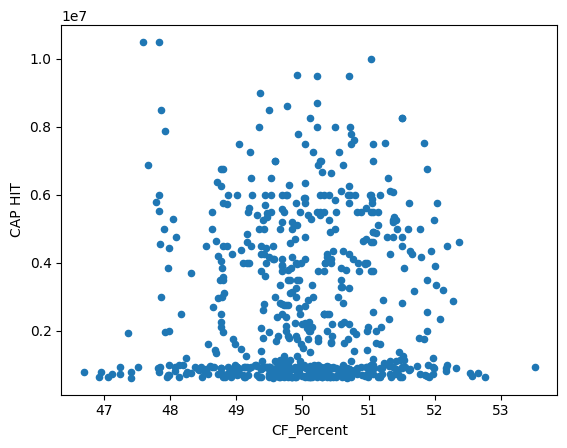

In [61]:
df_grouped_all.plot(x="CF_Percent", y="CAP HIT", kind="scatter")

In [ ]:
# df_spec['player'].groupby(['firstName', 'lastName']).agg({'CAP HIT': 'first', 'SALARY': 'first'}).reset_index()